In [19]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import sys
import json
import pickle
import gzip
import h5py
from glob import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
from importlib import reload
from collections import defaultdict, OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
new_rc_params = {'text.usetex': False, 'svg.fonttype': 'none' }
plt.rcParams.update(new_rc_params)
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
sys.path.append("../scripts")
from utils import set_spines, get_figure_size, count_items

In [2]:
ONEHOT = np.concatenate((np.zeros((6, 4), dtype=np.int8), np.diag(np.ones(4, dtype=np.int8))))

In [3]:
! ../scripts/fetch_embed_cons.py

- load processed genome: /bigdat1/pub/UCSC/hg19/bigZips/hg19.fa.cache.pkl
Loading bed: /home/chenken/Documents/github/SpliceBERT/examples/data/gencode.v41lift37.canonical.tx.bed.gz: 37770it [00:00, 420375.33it/s]
100%|█████████████████████████████████████████| 125/125 [00:06<00:00, 19.45it/s]


In [4]:
results = pickle.load(open("./embed_cons.pkl", "rb")) 

In [5]:
for k, v in results.items():
    print(k, v.shape)

ids_extend (1000, 1530)
splicebert (1000, 510, 512)
splicebert-human (1000, 510, 512)
phastcons (1000, 510)
phylop (1000, 510)
annotation (1000, 510, 12)


In [6]:
## load sequences(ids_extend), conservation scores(phastcons, phylop), 
##   and pre-computed nucleotide embeddings (SpliceBERT, SpliceBERT-Human)

results = pickle.load(open("./embed_cons.pkl", "rb")) # use samples
results["ids"] = list()
flanking = 250
for i in tqdm(range(results["ids_extend"].shape[0])):
    tmp = list()
    for p in range(510, 1020):
        substr = ONEHOT[results["ids_extend"][i, p-flanking:p+1+flanking]].reshape(-1).astype(np.int8)
        tmp.append(substr)
    tmp = np.stack(tmp)
    results["ids"].append(tmp)
results["ids"] = np.stack(results["ids"])
del results["ids_extend"]
for k, v in results.items():
    if v.ndim > 2:
        dim = v.shape[-1]
        v = v.reshape(-1, dim)
    else:
        v = v.reshape(-1)
    results[k] = v
ids, h1, h2, phastcons, phylop, annotation = [results[k] for k in ["ids", "splicebert", "splicebert-human", "phastcons", "phylop" ,"annotation"]]
keep = np.where((~np.isnan(phastcons)) & (~np.isnan(phylop)))[0]
ids = ids[keep]
h1 = h1[keep] # SpliceBERT
h2 = h2[keep] # SpliceBERT-human
phastcons = phastcons[keep]
phylop = phylop[keep]
annotation = annotation[keep]
print(ids.shape, h1.shape, h2.shape, phastcons.shape, phylop.shape, annotation.shape)

100%|██████████| 1000/1000 [00:05<00:00, 197.64it/s]


(506269, 2004) (506269, 512) (506269, 512) (506269,) (506269,) (506269, 12)


In [7]:
print(ids.shape, h1.shape, h2.shape)

(506269, 2004) (506269, 512) (506269, 512)


In [8]:
# normalize SpliceBERT and SpliceBERT-human embeddings
h1 = (h1 - np.mean(h1, axis=0, keepdims=True)) / np.std(h1, axis=0, keepdims=True) # SpliceBERT
h2 = (h2 - np.mean(h2, axis=0, keepdims=True)) / np.std(h2, axis=0, keepdims=True) # SpliceBERT-human

In [10]:
np.random.rand(2020)

# split train and test
in_train = np.random.rand(ids.shape[0]) > 0.2
print(count_items(in_train, fraction=True))
is_train = np.where(in_train)[0]
is_test = np.where(~in_train)[0]
print(len(is_train), len(is_test))

[[False, 100972, 0.199], [True, 405297, 0.801]]
405297 100972


In [12]:
# make labels
labels = np.zeros_like(phastcons)
labels[np.where(phastcons >= 0.8)[0]] = 1
print(count_items(labels, fraction=True))

[[0.0, 476963, 0.942], [1.0, 29306, 0.058]]


In [14]:
max_iter = 1000

from sklearn.linear_model import LogisticRegression
lr_onehot = LogisticRegression(max_iter=max_iter)
lr_vert = LogisticRegression(max_iter=max_iter)
lr_human = LogisticRegression(max_iter=max_iter)

In [15]:
# if os.path.exists("./mlm2cons_models.pkl"):
#     with open("./mlm2cons_models.pkl", "rb") as f:
#         lr_onehot, lr_vert, lr_human = pickle.load(f)
# else:
print("onehot")
lr_onehot.fit(ids[is_train], labels[is_train])
onehot_lr = lr_onehot.predict_proba(ids[is_test])[::, 1]
print(roc_auc_score(labels[is_test], onehot_lr), average_precision_score(labels[is_test], onehot_lr))

print("vert")
lr_vert.fit(h1[is_train], labels[is_train])
vert_lr = lr_vert.predict_proba(h1[is_test])[::, 1]
print(roc_auc_score(labels[is_test], vert_lr), average_precision_score(labels[is_test], vert_lr))

print("human")
lr_human.fit(h2[is_train], labels[is_train])
human_lr = lr_human.predict_proba(h2[is_test])[::, 1]
print(roc_auc_score(labels[is_test], human_lr), average_precision_score(labels[is_test], human_lr))

pickle.dump((lr_onehot, lr_vert, lr_human), open("./mlm2cons_models.pkl", "wb"), protocol=pickle.HIGHEST_PROTOCOL)

onehot
0.5334553022568775 0.06730556146639005
vert
0.8386391235692554 0.3561209976470553
human
0.7910117268966347 0.25407910877208906


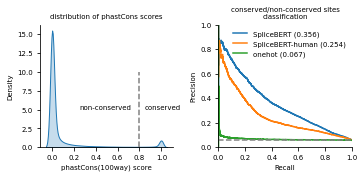

In [21]:
# set title/axes/legend font size
fs = 7
plt.rcParams['font.size'] = fs
plt.rcParams['axes.titlesize'] = fs
plt.rcParams['axes.labelsize'] = fs
plt.rcParams['xtick.labelsize'] = fs
plt.rcParams['ytick.labelsize'] = fs
plt.rcParams['legend.fontsize'] = fs
plt.rcParams['figure.titlesize'] = fs

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=get_figure_size(0.6, 0.6 * 0.5))
ax = axs[0]
# _ = ax.hist(cons_scores['cons'].numpy(), bins=400)
# _ = ax.hist(phastcons, bins=1000)
sns.kdeplot(phastcons, ax=ax, fill=True)
# ax.hist(phastcons, bins=100)
ax.vlines(0.8, 0, 10, color='grey', linestyle='--')
# annotate "unconserved" region (phastCons < 0.8)
ax.text(x=0.25, y=5, s="non-conserved", color='k', fontsize=fs, rotation=0)
ax.text(x=0.85, y=5, s="conserved", color='k', fontsize=fs, rotation=0)

# sns.distplot(phastcons, ax=ax, kde=True)
ax.set_xlabel("phastCons(100way) score")
ax.set_xticks(np.arange(0, 1.1, 0.2))
set_spines(ax)
ax.set_title("distribution of phastCons scores")
# ax.set_aspect('equal')

ax = axs[1]
p, r, _ = precision_recall_curve(labels[is_test], vert_lr)
ax.plot(r, p, label="SpliceBERT ({:.3f})".format(average_precision_score(labels[is_test], vert_lr)))

p, r, _ = precision_recall_curve(labels[is_test], human_lr)
ax.plot(r, p, label="SpliceBERT-human ({:.3f})".format(average_precision_score(labels[is_test], human_lr)))

p, r, _ = precision_recall_curve(labels[is_test], onehot_lr)
ax.plot(r, p, label="onehot ({:.3f})".format(average_precision_score(labels[is_test], onehot_lr)))

ax.legend(frameon=False)
ax.hlines(xmin=0, xmax=1, y=labels[is_test].sum() / len(is_test), color='grey', linewidth=1.5, linestyle='--')
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_xlim(left=0, right=1)
ax.set_ylim(bottom=0, top=1)
ax.set_title("conserved/non-conserved sites\nclassification")
set_spines(ax)

plt.tight_layout()

plt.savefig("pred_cons.svg")
plt.savefig("pred_cons.jpg", dpi=600)